In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [8]:
gDNA_c_file = '/project2/kribelba_1515/saadawy/barcode_gDNA_counts_dataset2.tsv'
mRNA_c_file = '/project2/kribelba_1515/saadawy/barcode_mRNA_counts_dataset2.tsv'
data_path = '/project2/kribelba_1515/data/EXTRA_seq/2024_data/endoSTARR_lib5p3/mapping/mapping_r2_to_BC_5p3_plDNA_lib_total_BCcount_57bp_from_R2end_ofhublib4p75tab_unique_BC_read_mappings_only_plus_inferred_TFsyntax_2025_04_04.csv'
mapping = pd.read_csv(data_path, sep=',')
mapping = mapping[['BC', 'Freq', 'inferred_name']]
mapping = mapping.rename(columns={'inferred_name': 'Enhancer'})
gDNA_counts = pd.read_csv(gDNA_c_file, sep='\t')
mRNA_counts = pd.read_csv(mRNA_c_file, sep='\t')
barcode_counts = pd.merge(gDNA_counts, mRNA_counts)
for i in range(1, 4): # looping over the replicate columns
 gDNA_col = f"gDNA_rep{i}"
 mRNA_col = f"mRNA_rep{i}"
    
# If gDNA is 0 but mRNA is positive, set mRNA to 0
 barcode_counts.loc[barcode_counts[gDNA_col] == 0, mRNA_col] = 0
replicate_columns = ['gDNA_rep1', 'gDNA_rep2', 'gDNA_rep3']
replicate_columns_mRNA = ['mRNA_rep1', 'mRNA_rep2', 'mRNA_rep3']

# compute total counts per barcode
barcode_counts['gDNA_Counts'] = barcode_counts[replicate_columns].sum(axis=1)
barcode_counts['mRNA_Counts'] = barcode_counts[replicate_columns_mRNA].sum(axis=1)
barcode_counts['mRNA/gDNA'] = barcode_counts['mRNA_Counts'] / barcode_counts['gDNA_Counts']

# how many replicates contribute to the total
barcode_counts['nonzero_replicates'] = (barcode_counts[replicate_columns] > 0).sum(axis=1)

In [9]:
mapping

,BC,Freq,Enhancer
0,AAAAAAAACACT,22,RUNX3_RUNX3_RUNX3_2
1,AAAAAAAACGGT,13,MYC_MYC_MYC_MYC_MYC_2
2,AAAAAAAATAAG,25,RUNX3_MYC_2
3,AAAAAAACCGCC,7,PU1_CTCF_1
4,AAAAAAACCGGC,20,MEF2_MEF2_2
...,...,...,...
287431,TTTTTTTTAAAT,103,MYC_PU1_3
287432,TTTTTTTTACAG,91,MYC_MYC_MYC_2
287433,TTTTTTTTATAC,123,FOXO_MYC_FOXO_1
287434,TTTTTTTTCGTT,116,PU1_IRF_PU1_3


In [10]:
valid_chars = {'A', 'T', 'G', 'C'}

def clean_mapping(df):
 mapping = df.dropna(subset=['BC'])  # remove any NaN barcodes
 mapping = mapping[
    (mapping['BC'].str.len() == 12) & 
    (mapping['BC'].apply(lambda x: set(x).issubset(valid_chars)))]
 return mapping
mapping = clean_mapping(mapping)

In [26]:
total_gDNA_thresholds = [10, 50, 100]

results = []
final = {} # dict containing all filter schemes

for total_gDNA_thresh in total_gDNA_thresholds:
        mapped_barcode_counts = pd.merge(
            barcode_counts, mapping, 
            left_on='sequence', right_on='BC', how='inner'
        )
        mapped_barcode_counts.drop(columns=['BC'], inplace=True)

        mapped_barcode_counts_filtered = mapped_barcode_counts[
        (mapped_barcode_counts['gDNA_Counts'] >= total_gDNA_thresh) &
         (mapped_barcode_counts['nonzero_replicates'] >= 2)
]

        mapped_barcode_counts_filtered['Enhancer'] = mapped_barcode_counts_filtered['Enhancer'].str.replace(r'_\d$', '', regex=True)
        intersected_count = len(mapped_barcode_counts_filtered)
        results.append((total_gDNA_thresh, intersected_count))
        final[total_gDNA_thresh] = mapped_barcode_counts_filtered[['sequence', 'gDNA_Counts', 'mRNA_Counts', 'mRNA/gDNA', 'Freq', 'Enhancer']]

results_df = pd.DataFrame(results, columns=['Total_gDNA_Counts_Threshold', 'Intersected_Barcodes'])

/tmp/SLURM_1607545/ipykernel_405102/58339266.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapped_barcode_counts_filtered['Enhancer'] = mapped_barcode_counts_filtered['Enhancer'].str.replace(r'_\d$', '', regex=True)
/tmp/SLURM_1607545/ipykernel_405102/58339266.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapped_barcode_counts_filtered['Enhancer'] = mapped_barcode_counts_filtered['Enhancer'].str.replace(r'_\d$', '', regex=True)
/tmp/SLURM_1607545/ipykernel_405102/58339266.py:18: SettingWithCop

In [31]:
results_df

,Total_gDNA_Counts_Threshold,Intersected_Barcodes
0,10,9483
1,50,9294
2,100,8869


In [33]:
# correlation between mapping frequency and total gDNA counts across different total_gDNA_counts_thresholds.
correlation_results = []

for total_gDNA_thresh, df in final.items():
    if not df.empty:
        correlation, p_value = stats.pearsonr(df['gDNA_Counts'], df['Freq'])
        correlation_results.append((total_gDNA_thresh, correlation, p_value))
    else:
        correlation_results.append((total_gDNA_thresh, None, None))

correlation_df = pd.DataFrame(correlation_results, columns=['Total_gDNA_Counts_Threshold', 'Correlation', 'P_Value'])
correlation_df = correlation_df.dropna()
correlation_df = correlation_df.sort_values("Total_gDNA_Counts_Threshold")

correlation_df

,Total_gDNA_Counts_Threshold,Correlation,P_Value
0,10,0.123614,1.308814e-33
1,50,0.121646,5.603582e-32
2,100,0.118131,6.216346e-29


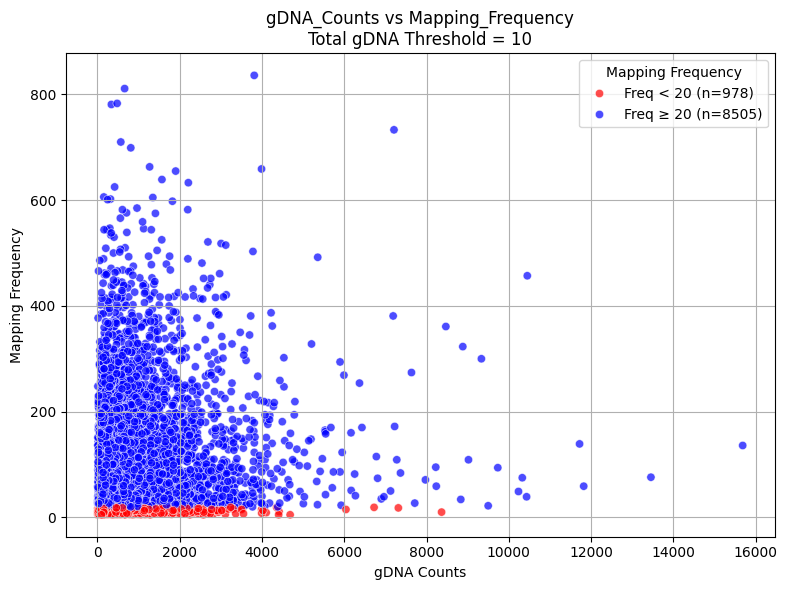

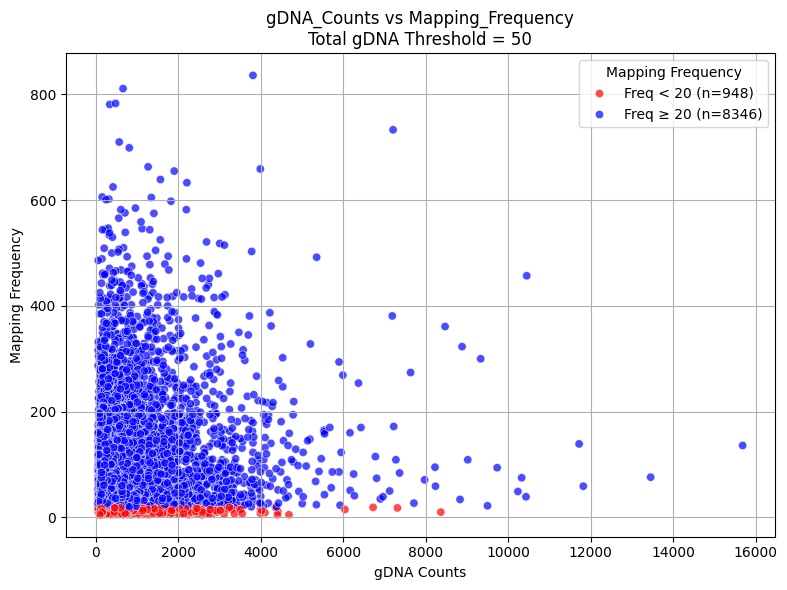

/tmp/SLURM_1607545/ipykernel_405102/3700889817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Freq_Category'] = df['Freq'].apply(lambda x: 'Freq < 20' if x < 20 else 'Freq ≥ 20')


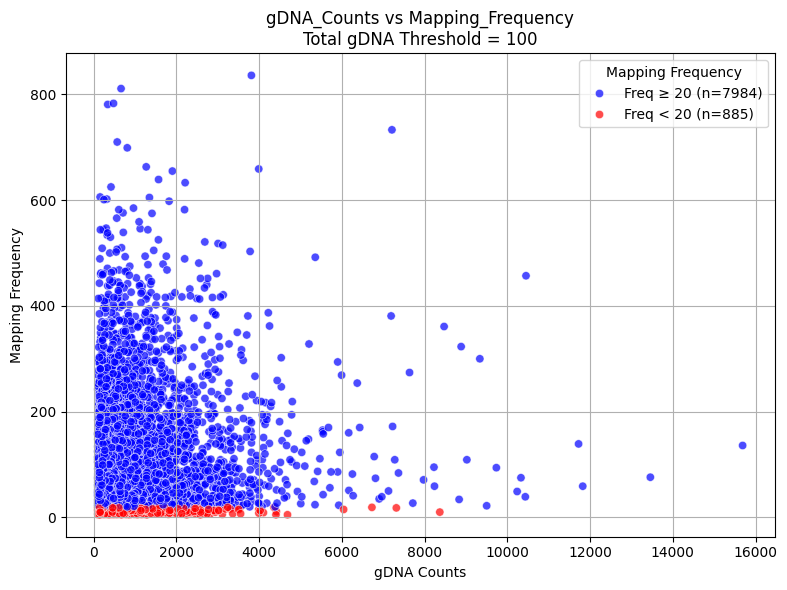

In [39]:
# scatter plot between gDNA_Counts and Nanopore Mapping_Counts
for total_gDNA_thresh, df in final.items():
    df['Freq_Category'] = df['Freq'].apply(lambda x: 'Freq < 20' if x < 20 else 'Freq ≥ 20')

    category_counts = df['Freq_Category'].value_counts()
    legend_labels = {
        'Freq < 20': f"Freq < 20 (n={category_counts.get('Freq < 20', 0)})",
        'Freq ≥ 20': f"Freq ≥ 20 (n={category_counts.get('Freq ≥ 20', 0)})"
    }
    
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(
        data=df,
        x='gDNA_Counts',
        y='Freq',
        hue='Freq_Category',
        palette={'Freq < 20': 'red', 'Freq ≥ 20': 'blue'},
        alpha=0.7
    )
    handles, labels = scatter.get_legend_handles_labels()
    updated_labels = [legend_labels[label] for label in labels if label in legend_labels]
    plt.legend(handles=handles, labels=updated_labels, title='Mapping Frequency')
    
    plt.title(f"gDNA_Counts vs Mapping_Frequency\nTotal gDNA Threshold = {total_gDNA_thresh}")
    plt.xlabel("gDNA Counts")
    plt.ylabel("Mapping Frequency")
    plt.grid(True)    
    plt.tight_layout()
    plt.show()

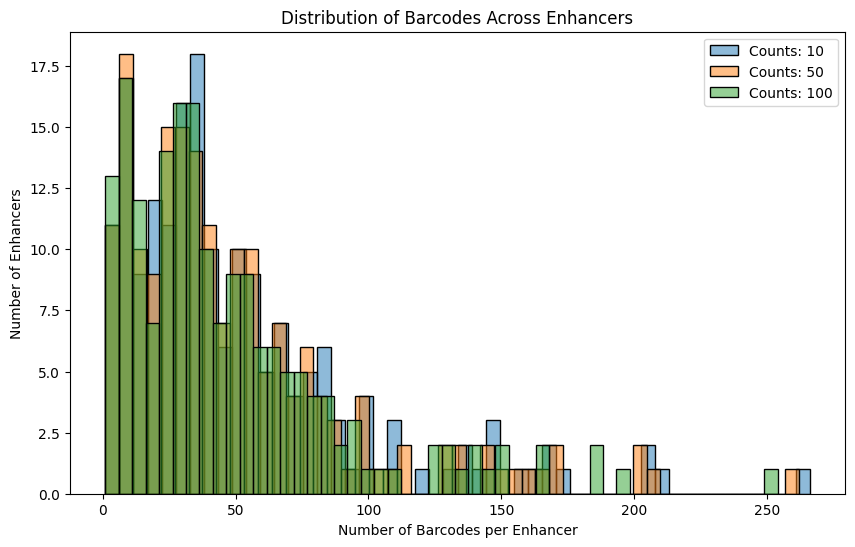

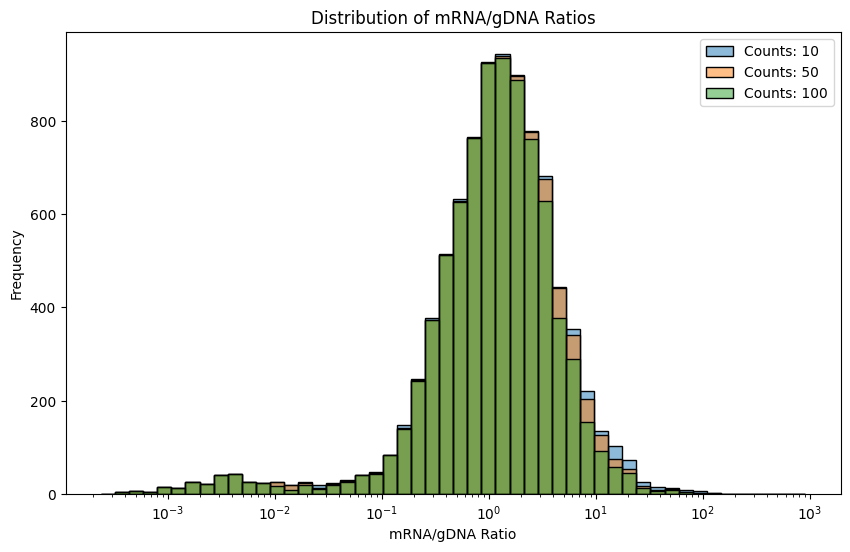

In [40]:
# Histogram distribution of barcodes across enhancers and distribution of mRNA/gDNA ratios

enhancer_counts_dict = {}
mRNA_gDNA_ratios = {}

for total_gDNA_thresh, df in final.items():
    merged_df = pd.merge(barcode_counts, df)
    merged_df.drop('nonzero_replicates', axis=1, errors='ignore', inplace=True)
    merged_df['Enhancer'] = merged_df['Enhancer'].str.replace(r'_\d$', '', regex=True)
    
    enhancer_counts_dict[total_gDNA_thresh] = merged_df['Enhancer'].value_counts()
    mRNA_gDNA_ratios[total_gDNA_thresh] = merged_df['mRNA/gDNA']

plt.figure(figsize=(10, 6))
for total_gDNA_thresh, counts in enhancer_counts_dict.items():
    sns.histplot(counts, bins=50, alpha=0.5, label=f"Counts: {total_gDNA_thresh}", log_scale=False, multiple='stack')

plt.xlabel("Number of Barcodes per Enhancer")
plt.ylabel("Number of Enhancers")
plt.title("Distribution of Barcodes Across Enhancers")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for total_gDNA_thresh, ratios in mRNA_gDNA_ratios.items():
    sns.histplot(ratios, bins=50, log_scale=True, alpha=0.5, label=f"Counts: {total_gDNA_thresh}", multiple='stack')

plt.xlabel('mRNA/gDNA Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of mRNA/gDNA Ratios')
plt.legend()
plt.show()

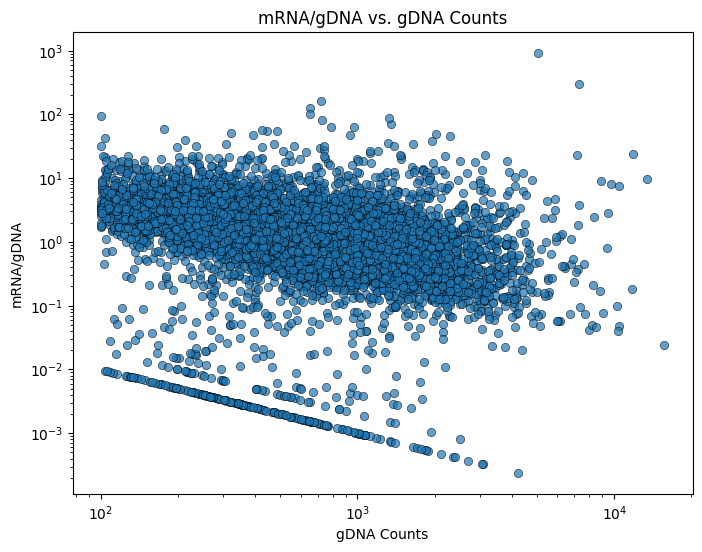

In [44]:
# plot between gDNA_Counts and mRNA/gDNA
df = final[100].copy()
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df, 
    x="gDNA_Counts", 
    y="mRNA/gDNA",
    edgecolor="black",
    alpha=0.7
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("gDNA Counts")
plt.ylabel("mRNA/gDNA")
plt.title("mRNA/gDNA vs. gDNA Counts")
plt.show()

/tmp/SLURM_1607545/ipykernel_405102/3074799823.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='gDNA', y='Num_Enhancers', palette='coolwarm')
/tmp/SLURM_1607545/ipykernel_405102/3074799823.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='gDNA', y='Total_Barcodes', palette='viridis')


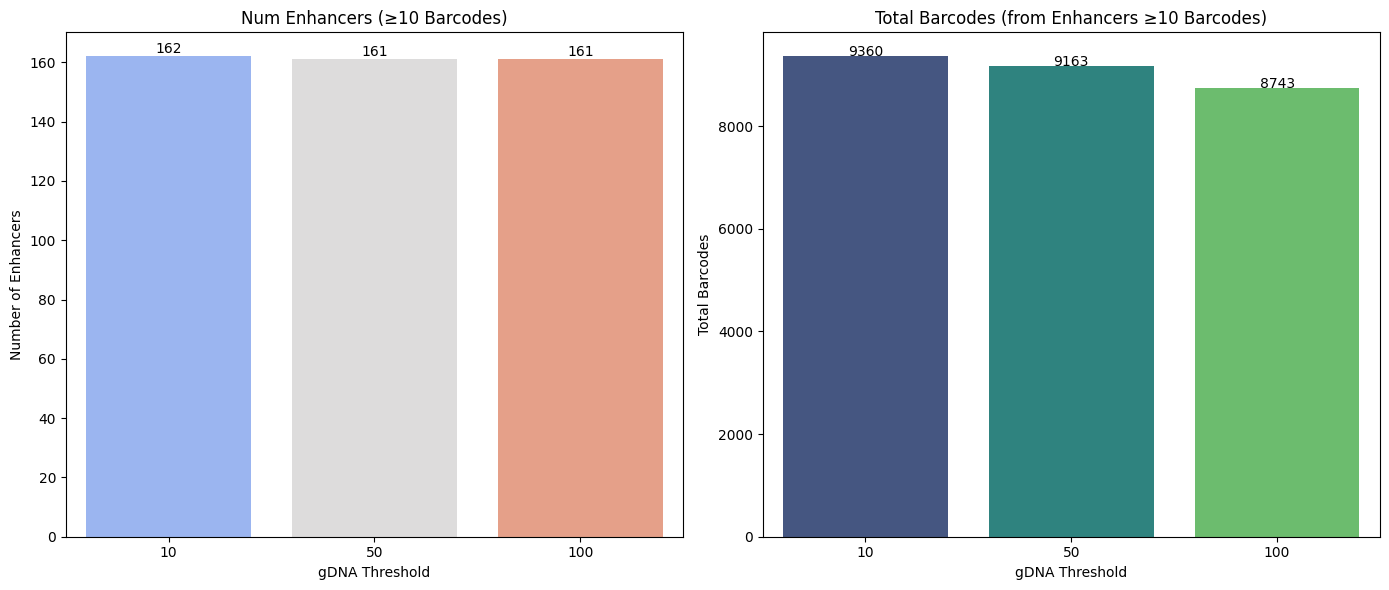

In [45]:
# what if we filter to keep only enhancers with more than 10 barcodes?

num_barcode_filter = 10
enhancer_counts_dict = {}

for total_gDNA_thresh, df in final.items():
    merged_df = pd.merge(barcode_counts, df)
    merged_df.drop('nonzero_replicates', axis=1, inplace=True)
    enhancer_counts_dict[total_gDNA_thresh] = merged_df['Enhancer'].value_counts()

enhancer_summary = {}
total_barcodes_summary = {}

for total_gDNA_thresh, counts in enhancer_counts_dict.items():
    # filter to keep only enhancers with ≥ num_barcode_filter barcodes
    filtered_counts = counts[counts >= num_barcode_filter]
    
    num_enhancers = filtered_counts.count()  # number of enhancers meeting threshold
    total_barcodes = filtered_counts.sum()   # Total number of barcodes meeting threshold

    condition_name = f"gDNA_{total_gDNA_thresh}"
    enhancer_summary[condition_name] = num_enhancers
    total_barcodes_summary[condition_name] = total_barcodes

enhancer_summary_df = pd.DataFrame.from_dict(enhancer_summary, orient='index', columns=['Num_Enhancers'])
total_barcodes_df = pd.DataFrame.from_dict(total_barcodes_summary, orient='index', columns=['Total_Barcodes'])

summary_df = enhancer_summary_df.join(total_barcodes_df)
summary_df.index.name = 'Condition'
summary_df.reset_index(inplace=True)

summary_df['gDNA'] = summary_df['Condition'].str.extract(r'gDNA_(\d+)')
summary_df.drop(columns=['Condition'], inplace=True)
summary_df = summary_df.astype({'gDNA': int})

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=summary_df, x='gDNA', y='Num_Enhancers', palette='coolwarm')
plt.title(f"Num Enhancers (≥{num_barcode_filter} Barcodes)")
plt.xlabel("gDNA Threshold")
plt.ylabel("Number of Enhancers")

for i, row in summary_df.iterrows():
    plt.text(i, row['Num_Enhancers'] + 1, str(row['Num_Enhancers']), ha='center')

plt.subplot(1, 2, 2)
sns.barplot(data=summary_df, x='gDNA', y='Total_Barcodes', palette='viridis')
plt.title(f"Total Barcodes (from Enhancers ≥{num_barcode_filter} Barcodes)")
plt.xlabel("gDNA Threshold")
plt.ylabel("Total Barcodes")

for i, row in summary_df.iterrows():
    plt.text(i, row['Total_Barcodes'] + 10, str(row['Total_Barcodes']), ha='center')

plt.tight_layout()
plt.show()

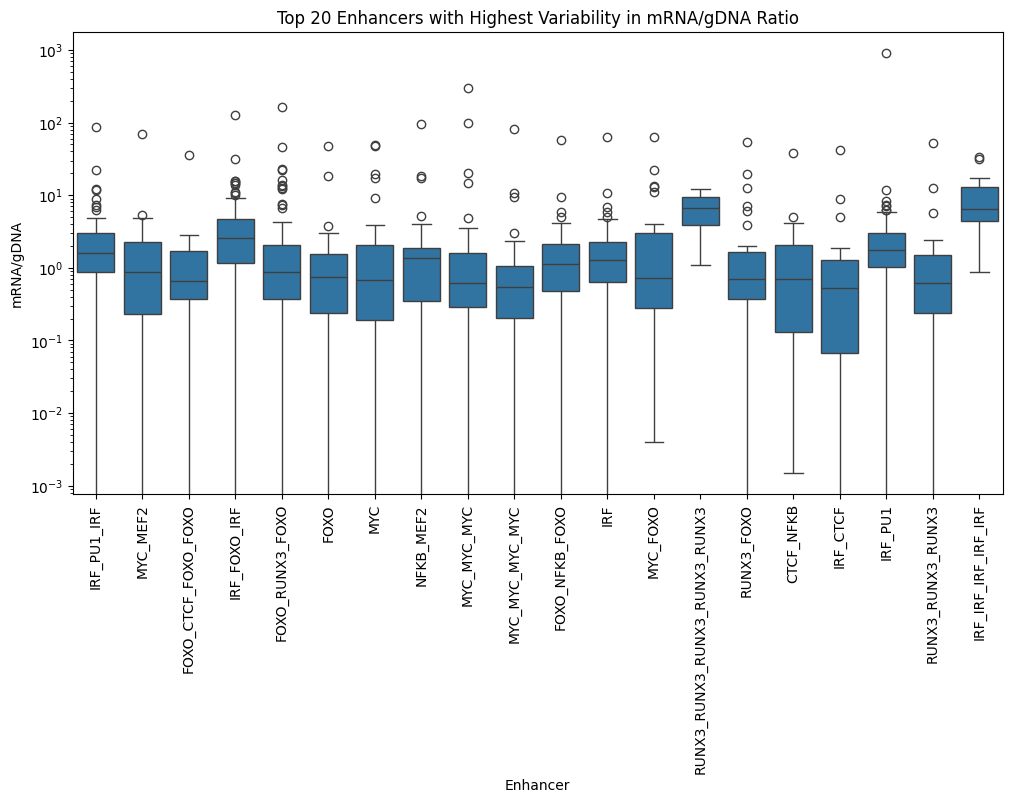

In [46]:
# top 20 enhancers with variability of mRNA/gDNA ratios
df = final[100].copy()

enhancer_variability = df.groupby("Enhancer")["mRNA/gDNA"].var()

top_enhancers = enhancer_variability.nlargest(20).index

df_top = df[df["Enhancer"].isin(top_enhancers)]

plt.figure(figsize=(12, 6))
sns.boxplot(x="Enhancer", y="mRNA/gDNA", data=df_top)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Top 20 Enhancers with Highest Variability in mRNA/gDNA Ratio")
plt.show()

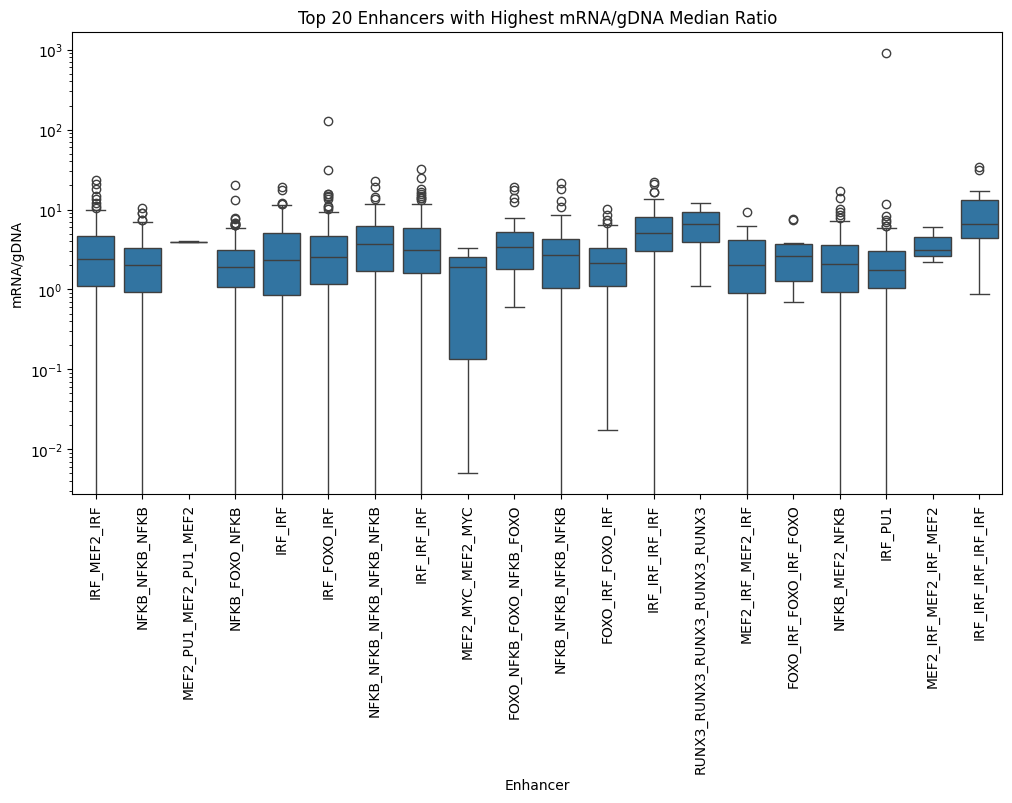

In [48]:
# top 20 enhancers with highest mRNA/gDNA median ratios

df = final[100].copy()

enhancer_median = df.groupby("Enhancer")["mRNA/gDNA"].median()

top_enhancers = enhancer_median.nlargest(20).index

df_top = df[df["Enhancer"].isin(top_enhancers)]

plt.figure(figsize=(12, 6))
sns.boxplot(x="Enhancer", y="mRNA/gDNA", data=df_top)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Top 20 Enhancers with Highest mRNA/gDNA Median Ratio")
plt.show()

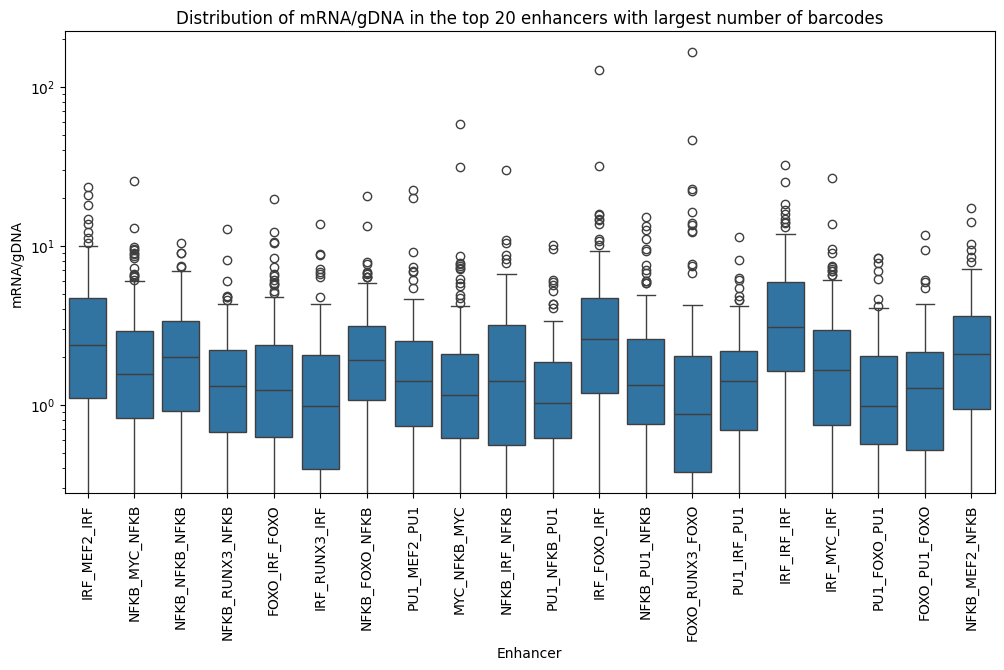

In [55]:
# mRNA/gDNA distribution of the top 20 enhancers with highest number of barcodes
df = final[100].copy()

top_enhancers = df["Enhancer"].value_counts().nlargest(20).index

# Filter the dataframe for these top enhancers
df_top = df[df["Enhancer"].isin(top_enhancers)]

plt.figure(figsize=(12, 6))
sns.boxplot(x="Enhancer", y="mRNA/gDNA", data=df_top)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Distribution of mRNA/gDNA in the top 20 enhancers with largest number of barcodes")
plt.show()

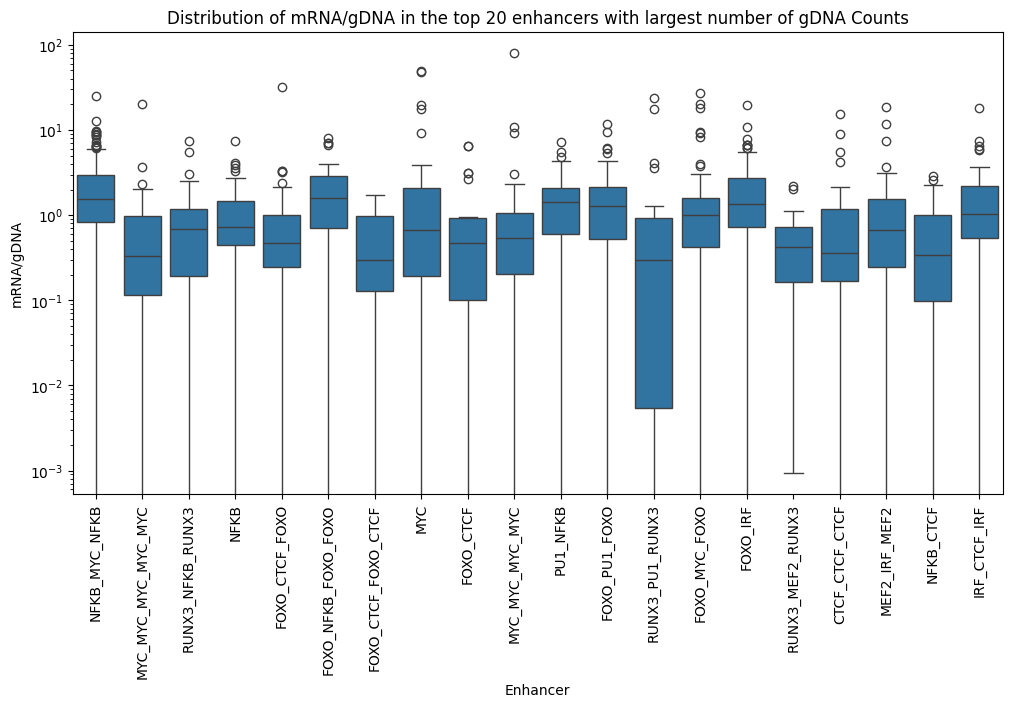

In [56]:
# mRNA/gDNA distribution of the top 20 enhancers with highest number of gDNA Counts
df = final[100].copy()

top_enhancers = df.nlargest(20, "gDNA_Counts")["Enhancer"]

# Filter the dataframe for these top enhancers
df_top = df[df["Enhancer"].isin(top_enhancers)]

plt.figure(figsize=(12, 6))
sns.boxplot(x="Enhancer", y="mRNA/gDNA", data=df_top)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Distribution of mRNA/gDNA in the top 20 enhancers with largest number of gDNA Counts")
plt.show()

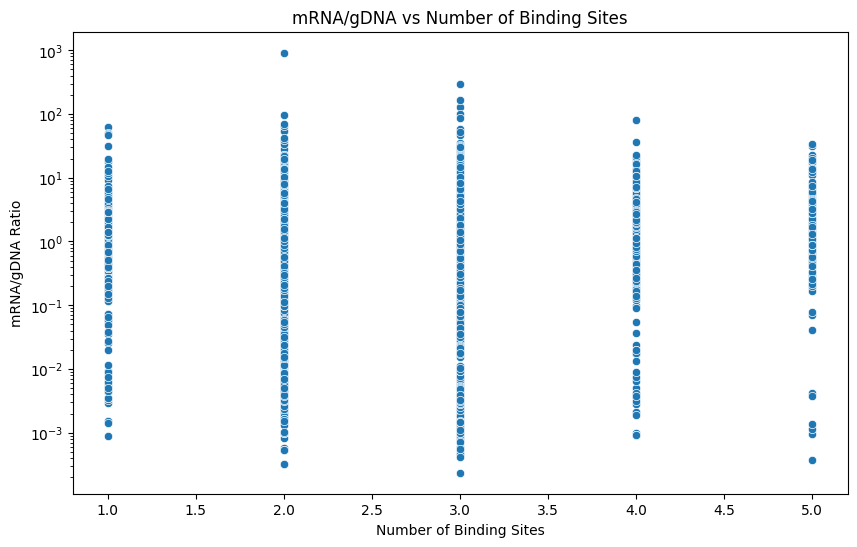

/tmp/SLURM_1607545/ipykernel_405102/3218055416.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=median_mrna_gdna.index, y=median_mrna_gdna.values, palette="viridis")


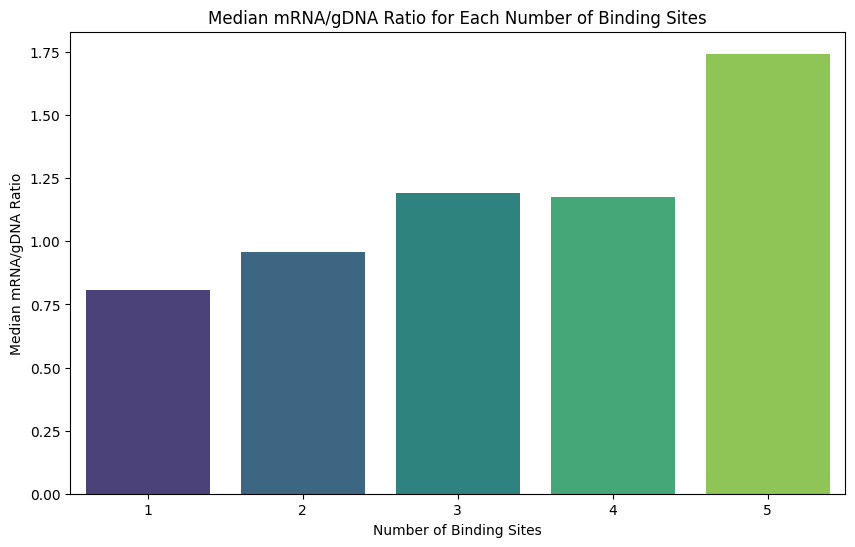

In [57]:
# categorize enhancers to how many binding sites they have and check mRNA/gDNA. 
# Usually, the more binding sites, the more we should expect to have a higher mRNA/gDNA ratio

df = final[100].copy()
df['Number of Binding Sites'] = df['Enhancer'].apply(lambda x: x.count('_') + 1)
median_mrna_gdna = df.groupby("Number of Binding Sites")["mRNA/gDNA"].median()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="Number of Binding Sites", y="mRNA/gDNA", data=df)
plt.title("mRNA/gDNA vs Number of Binding Sites")
plt.xlabel("Number of Binding Sites")
plt.ylabel("mRNA/gDNA Ratio")
plt.yscale('log')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=median_mrna_gdna.index, y=median_mrna_gdna.values, palette="viridis")
plt.title("Median mRNA/gDNA Ratio for Each Number of Binding Sites")
plt.xlabel("Number of Binding Sites")
plt.ylabel("Median mRNA/gDNA Ratio")
plt.show()

/tmp/SLURM_1607545/ipykernel_405102/790014933.py:3: FutureWarning: The provided callable <function median at 0x7fd21c7f5d00> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  pivot_table = df.pivot_table(index="Enhancer", values="mRNA/gDNA", aggfunc=np.median).sort_values(by="mRNA/gDNA", ascending=True)


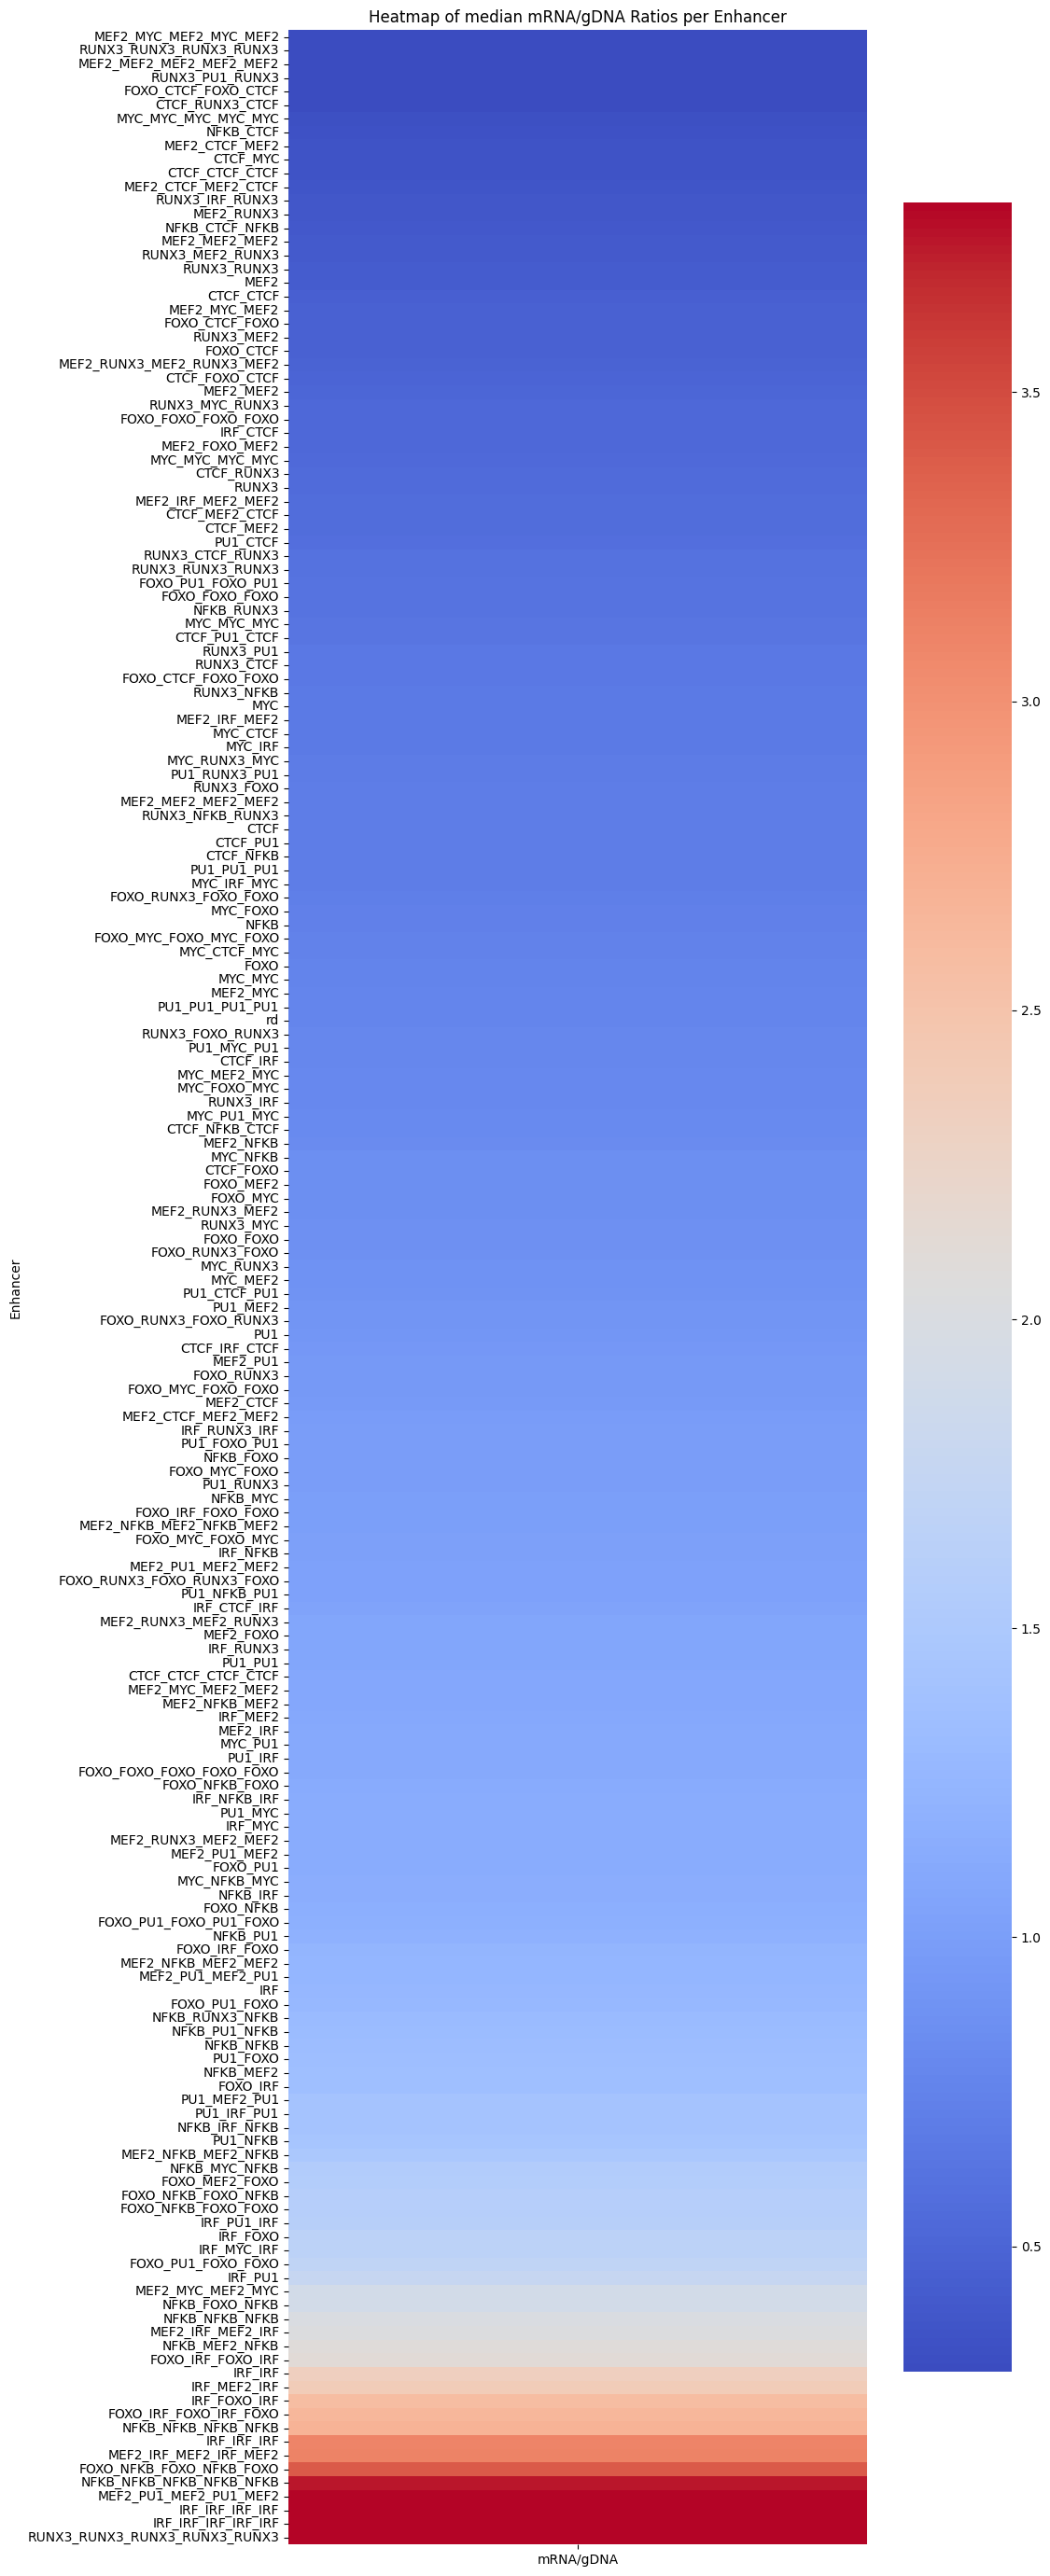

In [63]:
# heatmap for all enhancers' mRNA/gDNA ratios
df = final[100].copy()
pivot_table = df.pivot_table(index="Enhancer", values="mRNA/gDNA", aggfunc=np.median).sort_values(by="mRNA/gDNA", ascending=True)

plt.figure(figsize=(10, 35))
sns.heatmap(pivot_table, cmap="coolwarm", robust=True)
plt.title("Heatmap of median mRNA/gDNA Ratios per Enhancer")
plt.show()

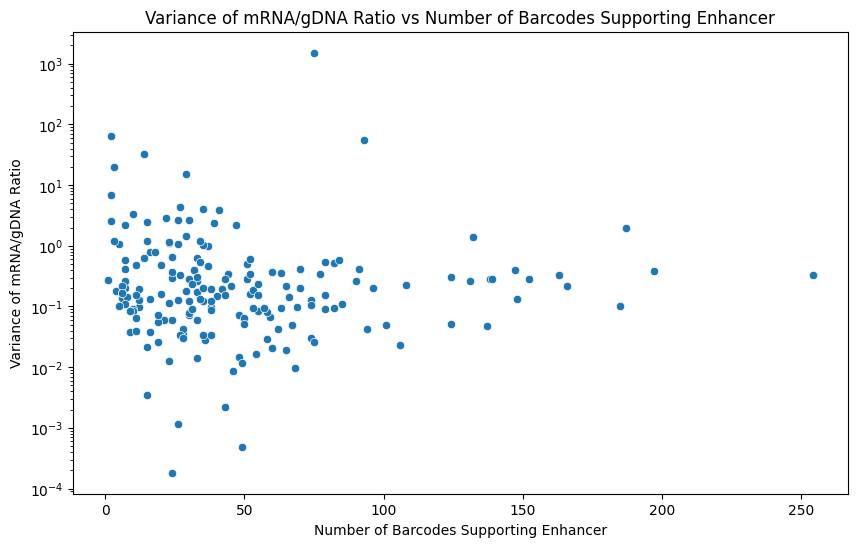

In [65]:
df = final[100].copy()
df = pd.merge(df, barcode_counts)
df.drop('nonzero_replicates', axis=1, inplace=True)
enhancer_sums = df.groupby("Enhancer")[["gDNA_rep1", "gDNA_rep2", "gDNA_rep3",
                                        "mRNA_rep1", "mRNA_rep2", "mRNA_rep3"]].sum()

ratios_list = []
for enhancer, row in enhancer_sums.iterrows():
    enhancer_ratios = []
    for i in range(1, 4):
        gDNA = row[f"gDNA_rep{i}"]
        mRNA = row[f"mRNA_rep{i}"]
        ratio = 0 if gDNA == 0 else mRNA / gDNA
        enhancer_ratios.append(ratio)
    
    ratios_list.append(enhancer_ratios)

ratios = pd.DataFrame(ratios_list, index=enhancer_sums.index, columns=[f"Ratio_rep{i}" for i in range(1, 4)])

enhancer_variance = ratios.var(axis=1)
variance_df = pd.DataFrame({"Enhancer": enhancer_variance.index, "Variance_mRNA/gDNA": enhancer_variance.values})

barcode_countss = df['Enhancer'].value_counts().reset_index()
barcode_countss.columns = ['Enhancer', 'Barcode Count']

variance_vs_barcodes = pd.merge(variance_df, barcode_countss, on="Enhancer")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Barcode Count', y='Variance_mRNA/gDNA', data=variance_vs_barcodes)
plt.title("Variance of mRNA/gDNA Ratio vs Number of Barcodes Supporting Enhancer")
plt.xlabel("Number of Barcodes Supporting Enhancer")
plt.ylabel("Variance of mRNA/gDNA Ratio")
plt.yscale('log')
plt.show()

In [66]:
df

,sequence,gDNA_Counts,mRNA_Counts,mRNA/gDNA,Freq,Enhancer,Freq_Category,gDNA_rep1,gDNA_rep2,gDNA_rep3,mRNA_rep1,mRNA_rep2,mRNA_rep3
0,CTCACATCCGCA,928,1084,1.168103,62,MEF2_RUNX3_MEF2,Freq ≥ 20,137,26,765,0,400,684
1,ACTACGTCCGGG,411,4019,9.778589,180,IRF_MEF2_IRF,Freq ≥ 20,78,62,271,2636,439,944
2,TCATATCCGTTA,165,986,5.975758,88,NFKB_MYC_NFKB,Freq ≥ 20,164,1,0,389,597,0
3,AGGATTACATGC,434,1378,3.175115,128,NFKB_NFKB_NFKB,Freq ≥ 20,216,2,216,0,441,937
4,ACTGTGTACAGT,182,291,1.598901,185,NFKB_RUNX3_NFKB,Freq ≥ 20,163,19,0,291,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8864,AATGCCGGCGTG,154,626,4.064935,52,IRF_IRF,Freq ≥ 20,0,2,152,0,0,626
8865,GTTACTATACGT,137,523,3.817518,75,PU1_MEF2_PU1,Freq ≥ 20,0,1,136,0,523,0
8866,TATAACCAAGAC,134,570,4.253731,44,IRF_MEF2_IRF,Freq ≥ 20,0,1,133,0,570,0
8867,CTAAGTACCTAT,196,1,0.005102,61,FOXO,Freq ≥ 20,0,1,195,0,1,0


In [68]:
df = final[100].copy()
final_df = pd.merge(df, barcode_counts)
if 'nonzero_replicates' in final_df.columns:
 final_df.drop('nonzero_replicates', axis=1, inplace=True)
df_for_mpra = final_df.drop(columns=['gDNA_Counts', 'mRNA_Counts', 'mRNA/gDNA', 'Freq', 'Freq_Category'], axis=1)

enhancer_counts = df_for_mpra["Enhancer"].value_counts()
df_for_mpra = df_for_mpra[df_for_mpra["Enhancer"].isin(enhancer_counts[enhancer_counts >= 10].index)]
df_for_mpra = df_for_mpra[[col for col in df_for_mpra.columns if col != "Enhancer"] + ["Enhancer"]]

In [71]:
df_for_mpra

,sequence,gDNA_rep1,gDNA_rep2,gDNA_rep3,mRNA_rep1,mRNA_rep2,mRNA_rep3,Enhancer
1,ACTACGTCCGGG,78,62,271,2636,439,944,IRF_MEF2_IRF
2,TCATATCCGTTA,164,1,0,389,597,0,NFKB_MYC_NFKB
3,AGGATTACATGC,216,2,216,0,441,937,NFKB_NFKB_NFKB
4,ACTGTGTACAGT,163,19,0,291,0,0,NFKB_RUNX3_NFKB
5,GTCGACAATATC,614,785,877,781,566,641,IRF_PU1_IRF
...,...,...,...,...,...,...,...,...
8864,AATGCCGGCGTG,0,2,152,0,0,626,IRF_IRF
8865,GTTACTATACGT,0,1,136,0,523,0,PU1_MEF2_PU1
8866,TATAACCAAGAC,0,1,133,0,570,0,IRF_MEF2_IRF
8867,CTAAGTACCTAT,0,1,195,0,1,0,FOXO


In [72]:
df_for_mpra.to_csv('df_for_mpra_dataset2.tsv', sep='\t', index=False)

In [74]:
df = final[100].copy()
final_df = pd.merge(df, barcode_counts)
if 'nonzero_replicates' in final_df.columns:
 final_df.drop('nonzero_replicates', axis=1, inplace=True)
df_for_mpra = final_df[['sequence', 'Enhancer']]

enhancer_counts = df_for_mpra["Enhancer"].value_counts()
df_for_mpra = df_for_mpra[df_for_mpra["Enhancer"].isin(enhancer_counts[enhancer_counts >= 10].index)]
df_for_mpra = df_for_mpra[[col for col in df_for_mpra.columns if col != "Enhancer"] + ["Enhancer"]]

df_for_mpra['Enhancer_barcode_count'] = df_for_mpra.groupby('Enhancer')['sequence'].transform('count')
df_for_mpra = df_for_mpra.drop(columns=['sequence'])
df_for_mpra = df_for_mpra.drop_duplicates(subset='Enhancer')

In [78]:
df_for_mpra

,Enhancer,Enhancer_barcode_count
1,IRF_MEF2_IRF,138
2,NFKB_MYC_NFKB,254
3,NFKB_NFKB_NFKB,197
4,NFKB_RUNX3_NFKB,139
5,IRF_PU1_IRF,94
...,...,...
1169,FOXO_PU1_FOXO_PU1,15
1176,MEF2_PU1_MEF2_MEF2,11
1353,MEF2_PU1_MEF2_PU1,15
1660,IRF_IRF_IRF_IRF_IRF,14


In [79]:
df_for_mpra.to_csv('enhancer_barcode_count_dataset2.tsv',sep='\t', index=False)